# <center> Exercise 1 Mel Spectrogram Implementation </center>

</br>
On this exercise, you are implementing from scratch to compute the mel spectrogram. This one is using <code>Numpy</code>. 
</br>

For this exercise, we use a 16-bit PCM wav file from here, called “example.wav”, which has a sampling frequency of 16000 Hz. The wav file is a clean speech signal comprising a single voice uttering one sentence. 

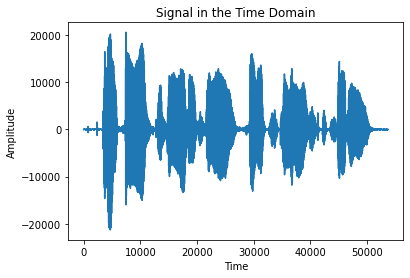

In [1]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import librosa.display 
sample_rate, signal = scipy.io.wavfile.read('example.wav')  # File assumed to be in the same directory


plt.figure(1)
plt.title("Signal in the Time Domain")
plt.plot(signal)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

<br>
<b>Step 1 : Pre emphasis </b>
</br>

<p>The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies.
A pre-emphasis filter is useful in several ways: (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).</p>

<p>The pre-emphasis filter can be applied to a signal \(x\) using the first order filter in the following equation:</p>

<p>\[y(t) = x(t) - \alpha x(t-1)\]</p>

<p>which can be easily implemented by using <code class="language-plaintext highlighter-rouge">signal</code> as input , where typical values for the filter coefficient (\(\alpha\)) are 0.95 or 0.97, <code class="language-plaintext highlighter-rouge">pre_emphasis = 0.97</code>:</p>


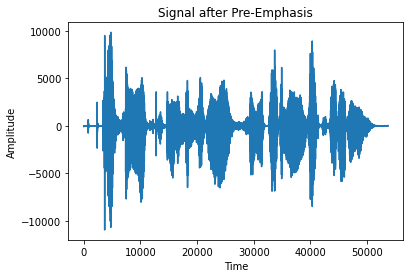

In [2]:
pre_emphasis = 0.97

#TO DO
###
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
#emphasized_signal = None
###

#Plot Pre emphasis signal
plt.figure(1)
plt.title("Signal after Pre-Emphasis")
plt.plot(emphasized_signal)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()
###

<p><a href="http://qr.ae/8GFgeI">Pre-emphasis has a modest effect in modern systems</a>, mainly because most of the motivations for the pre-emphasis filter can be achieved using mean normalization (discussed later in this post) except for avoiding the Fourier transform numerical issues which should not be a problem in modern FFT implementations.</p>

<p>The signal after pre-emphasis should have the following form :</p>
<p><img src="Signal_Pre_emphasis.png" alt="Signal_Pre_emphasis" title="Signal_Pre_emphasis" />

<br>
<b>Step 2 : Framing </b>
</br>

<p>After pre-emphasis, we need to split the signal into short-time frames.
The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time.
To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time.
Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.</p>

<p>Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames.
Popular settings are 25 ms for the frame size, <code class="language-plaintext highlighter-rouge">frame_size = 0.025</code> and a 10 ms stride (15 ms overlap), <code class="language-plaintext highlighter-rouge">frame_stride = 0.01</code>.</p>


In [3]:
frame_size, frame_stride = 0.025, 0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
#TO DO
###
# Get indices for all frames using pad_signal
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
#indices = None
#frames = None 
###
print(frames)


[[-70.   -16.1    0.48 ...   2.89  -0.9   -6.81]
 [ -4.36   9.43   5.64 ...   6.31  -5.57  10.19]
 [ -3.93   1.98  -3.93 ...  11.89 -11.81   1.77]
 ...
 [ -4.89   1.02  -4.89 ...  -4.89  -8.98   4.81]
 [  3.51   7.6   15.81 ... -11.39  -0.72   6.28]
 [ -3.93  -1.02   1.98 ...  10.    -6.7   -2.91]]


<b>Your result should be:</b> 


[[-70.   -16.1    0.48 ...   2.89  -0.9   -6.81]  <br/>
 [ -4.36   9.43   5.64 ...   6.31  -5.57  10.19] <br/>
 [ -3.93   1.98  -3.93 ...  11.89 -11.81   1.77] <br/> 
 ... <br/>
 [ -4.89   1.02  -4.89 ...  -4.89  -8.98   4.81] <br/>
 [  3.51   7.6   15.81 ... -11.39  -0.72   6.28] <br/>
 [ -3.93  -1.02   1.98 ...  10.    -6.7   -2.91]] <br/>


<br>
<b>Step 3 : Window </b>
</br>

<p>After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:</p>

<p>\[w[n] = 0.54 − 0.46 cos ( \frac{2πn}{N − 1} )\]</p>

<p>where, \(0 \leq n \leq N - 1\), \(N\) is the window length. Plotting the previous equation yields the following plot:</p>

<p class="half-size-center"><img src="hamming_window.jpg" alt="Hamming Window" title="Hamming Window" />


<p>There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.  Using the <code>numpy.hamming </code> to get a window function with <code>frame_length,</code> then apply it to the frames</p>




In [4]:
#TO DO
#frames *= None
frames *= numpy.hamming(frame_length)
###
print(frames)

[[-5.6        -1.28891825  0.0385095  ...  0.23185927 -0.07205133
  -0.5448    ]
 [-0.3488      0.75493783  0.4524866  ...  0.50623945 -0.44591768
   0.8152    ]
 [-0.3144      0.15851293 -0.31529652 ...  0.95391236 -0.94547357
   0.1416    ]
 ...
 [-0.3912      0.08165817 -0.39231551 ... -0.39231551 -0.71891216
   0.3848    ]
 [ 0.2808      0.60843346  1.2684066  ... -0.9137983  -0.05764106
   0.5024    ]
 [-0.3144     -0.08165817  0.15885168 ...  0.80228121 -0.53638213
  -0.2328    ]]


<b>the frames after applied Hamming window should be</b>

[[-5.6        -1.28891825  0.0385095  ...  0.23185927 -0.07205133
  -0.5448    ] <br/>
 [-0.3488      0.75493783  0.4524866  ...  0.50623945 -0.44591768
   0.8152    ] <br/>
 [-0.3144      0.15851293 -0.31529652 ...  0.95391236 -0.94547357
   0.1416    ] <br/>
 ... <br/>
 [-0.3912      0.08165817 -0.39231551 ... -0.39231551 -0.71891216
   0.3848    ] <br/>
 [ 0.2808      0.60843346  1.2684066  ... -0.9137983  -0.05764106
   0.5024    ] <br/>
 [-0.3144     -0.08165817  0.15885168 ...  0.80228121 -0.53638213
  -0.2328    ]] <br/>



<br>
<b>Step 4 : Fourier-Transform and Power Spectrum </b>
</br>
<p>We can now do an \(N\)-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where \(N\) is typically 256 or 512, <code class="language-plaintext highlighter-rouge">NFFT = 512</code>; and then compute the power spectrum (periodogram) using the following equation:</p>

<p>\[P = \frac{|FFT(x_i)|^2}{NFFT}\]</p>

<p>where, \(x_i\) is the \(i^{th}\) frame of signal \(x\). This could be implemented by apply <code>numpy.fft.rfft</code> with <code>NFFT=512</code> to the frames </p>. Note that the output of fourier transfomation has real part and imaginary part, so we need apply <code>numpy.absolute</code> to compute amplitude spectrum of fourier transformation

In [5]:
#TO DO
###
NFFT = 512
#mag_frames = None # compute amplitude spectrum of fourier transformation
#pow_framse = None # compute the power spectrum
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT),dtype="float32")  # Amplitude spectrum of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
print(pow_frames.shape)
###


(333, 257)


<b>the Power spectrum should be</b>

[[2.53361093e+03  2.02515128e+03  9.61055240e+02 ... 1.60025526e+02
  1.08999161e+02 4.85055906e+01] </br>
  
 [1.77256255e+02 4.06023372e+02 6.84585115e+02 ... 9.69173079e+02
  4.06517624e+02 2.58204140e+02] </br>
  
 [1.81764369e+03 1.46892965e+03 7.81674998e+02 ... 8.65308575e+02
  6.01207007e+01 9.69672478e+00] </br>

... </br>

[8.14155932e+00 1.71206377e+02 3.81847959e+02 ... 2.84096099e+01
  5.86398849e+01 7.70327523e+01] </br>

[8.07269107e+02 7.53715596e+02 6.07679463e+02 ... 5.07548901e+01
  8.32175967e+01 9.69677529e+01] </br>

[2.66811133e+02 5.33266698e+02 8.43624762e+02 ... 1.02673648e+01
  2.27448006e+00 7.55334841e-03]] </br>

<br>
<b>Step 5 : Get mel scale</b>
</br>
<p>The final step to computing filter banks is applying triangular filters, typically 40 filters, <code class="language-plaintext highlighter-rouge">nfilt = 40</code> on a Mel-scale to the power spectrum to extract frequency bands.
The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies.
We can convert between Hertz (\(f\)) and Mel (\(m\)) using the following equations:</p>

<p>\[m = 2595 \log_{10} (1 + \frac{f}{700})\]</p>

<p>\[f = 700 (10^{m/2595} - 1) \]</p>

<p>Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0, as shown in this figure:</p>

<p><img src="mel_filters.jpg" alt="Mel-Scaled Filters" title="Mel-Scaled Filters" />
<em>Filter bank on a Mel-Scale</em></p>

<p>This can be modeled by the following equation :</p>
<p><img src="function.jpg" alt="Mel-Scaled Filters" title="Mel-Scaled Filters"/>

In [9]:
# Since it is quite complicated, I do the implementation for you
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
# TODO
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
###

filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = numpy.log10(filter_banks) 
print(filter_banks)

[[2.10645051 1.76645889 1.79517002 ... 2.47054701 2.27586057 1.95872775]
 [2.52535309 2.44770514 2.09538367 ... 2.55932335 2.48497134 2.07001011]
 [2.37674471 1.95935578 1.59461635 ... 2.6249777  2.49312128 2.0068603 ]
 ...
 [1.32434763 1.7160782  1.45835836 ... 2.60053387 3.07717794 2.68459729]
 [1.98174702 1.40208003 1.10161399 ... 2.49361731 2.86018852 2.1511202 ]
 [1.3886474  1.17183451 1.56355693 ... 2.59094337 2.55923659 1.69511739]]


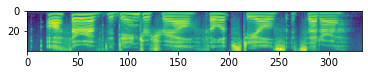

In [8]:
plt.imshow(filter_banks.T, interpolation='nearest')
plt.show()

<b>the output should be </b>
array([[2.10645051, 1.76645889, 1.79517002, ..., 2.47054701, 2.27586057,
        1.95872775], <br/>
       [2.52535309, 2.44770514, 2.09538367, ..., 2.55932335, 2.48497134,
        2.07001011], <br/>
       [2.37674471, 1.95935578, 1.59461635, ..., 2.6249777 , 2.49312128,
        2.0068603 ], <br/>
       ..., <br/>
       [1.32434763, 1.7160782 , 1.45835836, ..., 2.60053387, 3.07717794,
        2.68459729], <br/>
       [1.98174702, 1.40208003, 1.10161399, ..., 2.49361731, 2.86018852,
        2.1511202 ], <br/>
       [1.3886474 , 1.17183451, 1.56355693, ..., 2.59094337, 2.55923659,
        1.69511739]]) <br/>

<p>The mel spectrogram should look like :</p>
<p><img src="mel_spectrogram.png" alt="mel_spectrogram" title="mel_spectrogram" />